# BEM 114 HW 3

Group members
- Hannah Chen (2132624)
- Eileen Li (2158481)
- Victor Li (2158793)

Data needed:
- crsp_1926_2020.csv
- bcwlist.xlsx

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
# import warnings
# warnings.filterwarnings('ignore')

def read_bcwlist():
    df = pd.read_excel('bcwlist.xlsx', skiprows=2)
    return df[df.columns[:4]].copy()


def read_data():
    crsp = pd.read_csv('crsp_1926_2020.csv')

    crsp['PRC'] = crsp['PRC'].apply(lambda x : x if x > 0 else np.nan)
    crsp.drop(['SHRCD', 'EXCHCD'], inplace=True, axis = 'columns')
    crsp['RET'] = pd.to_numeric(crsp['RET'], errors = 'coerce')

    # # SHIFT RETURNS so that each row contains next monthly returns
    # crsp['RET'] = crsp.groupby('PERMNO')['RET'].shift(-1)

    return crsp

# Problem 1

In [2]:
bcw = read_bcwlist()
bcw = bcw.dropna()
bcw.head()
crsp = read_data()
# date is end of the month
crsp['date'] = crsp['date'].apply(lambda x: int(x[:4] + x[5:7]))
crsp.head()
# filter crsp for best companies
crsp = crsp[crsp['PERMNO'].isin(bcw[~bcw['permno'].isna()]['permno'].values)]
# calculate next month returns
crsp['SHIFT_RET'] = crsp.groupby('PERMNO')['RET'].shift(-1)

<ipython-input-2-1f35b73ca56c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp['SHIFT_RET'] = crsp.groupby('PERMNO')['RET'].shift(-1)


In [3]:
crsp

,PERMNO,date,PRC,RET,SHROUT,SHIFT_RET
14054,10078,198602,NaN,NaN,NaN,NaN
14055,10078,198603,NaN,NaN,27108.0,0.111588
14056,10078,198604,NaN,0.111588,27108.0,0.111969
14057,10078,198605,18.000,0.111969,27108.0,-0.118056
14058,10078,198606,15.875,-0.118056,27179.0,-0.039370
...,...,...,...,...,...,...
4700009,93374,202008,52.570,0.030582,111519.0,-0.023207
4700010,93374,202009,50.910,-0.023207,111519.0,-0.124141
4700011,93374,202010,44.590,-0.124141,111645.0,0.086342
4700012,93374,202011,48.440,0.086342,111645.0,0.075351


In [4]:
def get_months(start_month=198403, end_month=199301):
    year, month = start_month // 100, start_month % 100
    end_year, end_month = end_month // 100, end_month % 100
    while year < end_year or (year == end_year and month <= end_month):
        yield year * 100 + month
        month += 1
        if month > 12:
            year += 1
            month = 1

In [5]:
crsp[crsp['date'] == 198410]['RET'].isna().sum()

1

In [6]:
def get_portfolio_data(start_month=198403, end_month=199301):
    """Returns DataFrame for portfolio returns of best companies from
    start month to end month.

    Args:
    start_month: month before the first month of portfolio returns
    - if portfolio is formed on 4/1/1984, then start_month is 198403
    end_month: month before last month of portfolio returns
    - if portfolio runs until end of 2/1993, then end_month is 199301

    Returns: DataFrame with columns:
    month: month of portfolio returns
    rebalance: whether portfolio was rebalanced at the end of that month
    equal_weighted_return: return of equal weighted portfolio
    value_weighted_return: return of value weighted portfolio

    Note: returns are for the next month
    """

    # Find best companies
    start_year = start_month // 100
    bcw_init_df = bcw[bcw['year'] == start_year]
    crsp_init_month = crsp[crsp['date'] == start_month]
    bcw_init_in_crsp = bcw_init_df[bcw_init_df['permno'].isin(crsp_init_month['PERMNO'].unique())]
    best_companies = bcw_init_in_crsp['permno'].values  # list of PERMNOs of best companies to work for

    prev_stock_df = None
    prev_month_stocks = set()

    portfolio_data = {
        'month': [],
        'rebalance': [],
        'equal_weighted_return': [],
        'value_weighted_return': []
    }

    for month in get_months(start_month, end_month):

        crsp_month = crsp[crsp['date'] == month]

        # Filter crsp for best companies to work for to find returns
        stock_df = crsp_month[crsp_month['PERMNO'].isin(best_companies)].copy()
        stock_df['SIZE'] = stock_df['SHROUT'] * stock_df['PRC']
        stock_df.dropna(subset='SIZE', inplace=True)
        month_stocks = set(stock_df['PERMNO'])

        # Re-balance when the set of stocks from previous month to current month
        # are different.
        # Re-balancing occurs during initialization, listing, and de-listing (in
        # all three cases, the sets of active stocks will be different). For
        # simplicity, we also rebalance when a company's data for a month suddenly
        # becomes unavailable. This event is rare.
        rebalance = month_stocks != prev_month_stocks

        if rebalance:
            # Form rebalanced portfolio weights

            # Weights for equal weighted is 1 / n, where n is the number of stocks
            stock_df['EQUAL_WEIGHTS'] = np.ones(len(stock_df)) / len(stock_df)
            # Weights for value weighted is proportional to its market cap
            stock_df['VALUE_WEIGHTS'] = stock_df['SIZE'] / stock_df['SIZE'].sum()
        else:
            # Increase / decrease weights depending on returns; then normalize
            weights = prev_stock_df['EQUAL_WEIGHTS'] * (1 + prev_stock_df['SHIFT_RET'])
            stock_df['EQUAL_WEIGHTS'] = weights.values
            stock_df['EQUAL_WEIGHTS'] /= stock_df['EQUAL_WEIGHTS'].sum()
            weights = prev_stock_df['VALUE_WEIGHTS'] * (1 + prev_stock_df['SHIFT_RET'])
            stock_df['VALUE_WEIGHTS'] = weights.values
            stock_df['VALUE_WEIGHTS'] /= stock_df['VALUE_WEIGHTS'].sum()

        # Set nan returns to zero
        # nan's in SHIFT_RET may be due to delisted companies
        stock_df['SHIFT_RET'] = stock_df['SHIFT_RET'].fillna(0)

        # Returns are the dot product of weights and returns
        equal_weighted_return = stock_df['EQUAL_WEIGHTS'] @ stock_df['SHIFT_RET']
        value_weighted_return = stock_df['VALUE_WEIGHTS'] @ stock_df['SHIFT_RET']

        # add month data to portfolio_data
        portfolio_data['month'].append(month)
        portfolio_data['rebalance'].append(rebalance)
        portfolio_data['equal_weighted_return'].append(equal_weighted_return)
        portfolio_data['value_weighted_return'].append(value_weighted_return)

        prev_stock_df = stock_df
        prev_month_stocks = month_stocks

    return pd.DataFrame(portfolio_data)

In [7]:
df1 = get_portfolio_data(start_month=198403, end_month=199301)
print("tail of df1: \n", df1.tail())
df2 = get_portfolio_data(start_month=199302, end_month=199712)
print("head of df2: \n", df2.head())
print("tail of df2: \n", df2.tail())

tail of df1: 
       month  rebalance  equal_weighted_return  value_weighted_return
102  199209       True               0.035094              -0.003413
103  199210       True               0.051378               0.039535
104  199211       True               0.035203               0.005676
105  199212       True               0.029577               0.006163
106  199301      False               0.020364               0.026731
head of df2: 
     month  rebalance  equal_weighted_return  value_weighted_return
0  199302       True               0.027729               0.003343
1  199303      False              -0.017402              -0.032521
2  199304       True               0.041630               0.045255
3  199305       True              -0.025528              -0.032398
4  199306       True              -0.017900              -0.049532
tail of df2: 
      month  rebalance  equal_weighted_return  value_weighted_return
54  199708      False               0.053154               0.037854
55 

In [8]:
dfs = []
for year in range(1998, 2021):
    df = get_portfolio_data(start_month=year * 100 + 1, end_month=year * 100 + 12)
    dfs.append(df)
df = pd.concat([df1, df2] + dfs)
del df1, df2, dfs

In [9]:
df

,month,rebalance,equal_weighted_return,value_weighted_return
0,198403,True,0.003457,0.021974
1,198404,False,-0.058561,-0.046734
2,198405,False,0.048625,0.013125
3,198406,False,-0.043480,-0.006870
4,198407,False,0.124055,0.116919
...,...,...,...,...
7,202008,False,-0.049938,-0.041617
8,202009,False,-0.036004,-0.049378
9,202010,False,0.150504,0.136014
10,202011,False,0.059573,0.032699


In [10]:
print(f"number of times rebalancing: {df['rebalance'].sum()} / {len(df)} = {df['rebalance'].sum() / len(df)}")

number of times rebalancing: 78 / 442 = 0.17647058823529413


# Problem 2

In [11]:
df = df.set_index('month')

In [12]:
def stats(df, col):
  avg = df[col].mean()
  vol = (df[col] - df['RF']/100).std()
  sharpe = (df[col] - df['RF']/100).mean() / vol
  print(f'mean = {avg}')
  print(f'volatility = {vol}')
  print(f'sharpe ratio = {sharpe}')

In [19]:
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, skipfooter=61, index_col=0, engine='python')
ff = ff.shift(-1)
ff_mom = pd.read_csv('F-F_Momentum_Factor.CSV', skiprows=13, skipfooter=102, index_col=0, engine='python')
ff_mom = ff_mom.rename(columns=lambda x: x.strip())
ff_mom = ff_mom.shift(-1)
ff = pd.merge(ff, ff_mom, left_index=True, right_index=True)
ff = ff.dropna()
ff

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
196307,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
196308,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
196309,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
196310,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74
196311,1.83,-2.10,-0.02,0.03,-0.07,0.29,1.75
...,...,...,...,...,...,...,...
202209,7.83,1.86,8.05,3.07,6.52,0.23,3.87
202210,4.60,-2.67,1.38,6.01,3.11,0.29,-2.01
202211,-6.41,-0.16,1.32,0.09,4.19,0.33,4.52
202212,6.65,4.43,-4.05,-2.62,-4.53,0.35,-15.96


In [20]:
df_ff = pd.merge(df, ff, left_index=True, right_index=True)
print('equal weighted portfolio:')
stats(df_ff, "equal_weighted_return")
print()
print('value weighted portfolio:')
stats(df_ff, "value_weighted_return")

equal weighted portfolio:
mean = 0.012248898240054026
volatility = 0.0530463844718014
sharpe ratio = 0.1791957296434376

value weighted portfolio:
mean = 0.01075124248678067
volatility = 0.052222832690029794
sharpe ratio = 0.15334345926099635


In [21]:
def get_capm(series: pd.Series, print_capm=True):
    # market series
    ff_aligned = ff.loc[series.index]
    market_premium = ff_aligned['Mkt-RF']/100
    series = series - ff_aligned['RF']/100

    Y = series.values.reshape(-1, 1)
    X = market_premium.values.reshape(-1, 1)
    X = sm.add_constant(X)
    if (len(Y) != len(X)):
      print(X)
      print(len(Y), len(X))
    model = sm.OLS(Y,X)
    results = model.fit()
    
    alpha, beta, p = results.params[0], results.params[1], results.pvalues[0]

    if print_capm:
        print(f"CAPM for the strategy: Rp - Rf = {alpha:.5f} + {beta:.5f} (RM - Rf) + epsp", )
        print(f"p-value: ({p})")
    return alpha, beta, p

def get_ff3(series: pd.Series, print_ff3=True):
    ff_aligned = ff.loc[series.index]
    X = ff_aligned[['Mkt-RF', 'SMB', 'HML']] / 100
    series = series - ff_aligned['RF'] / 100

    Y = series.values.reshape(-1, 1)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()

    if print_ff3:
        print(results.params)
        print(f"p-value: ({results.pvalues[0]})")
    return results.params

def get_carhart(series: pd.Series, print_carhart=True):
    ff_aligned = ff.loc[series.index]
    X = ff_aligned[['Mkt-RF', 'SMB', 'HML', 'Mom']] / 100
    series = series - ff_aligned['RF'] / 100

    Y = series.values.reshape(-1, 1)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()

    if print_carhart:
        print(results.params)
        print(f"p-value: ({results.pvalues[0]})")
    return results.params

def get_ff5(series: pd.Series, print_ff5=True):
    # series = series[series.index >= 196307]
    ff_aligned = ff.loc[series.index]
    X = ff_aligned[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] / 100
    series = series - ff_aligned['RF'] / 100

    Y = series.values.reshape(-1, 1)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()

    if print_ff5:
        print(results.params)
        print(f"p-value: ({results.pvalues[0]})")
    return results.params

In [22]:
print('capm for equal weighted:')
get_capm(df['equal_weighted_return'])
print('capm for value weighted:')
get_capm(df['value_weighted_return'])
print()

print('ff3 for equal weighted:')
get_ff3(df['equal_weighted_return'])
print('ff3 for value weighted:')
get_ff3(df['value_weighted_return'])
print()

print('carhart for equal weighted:')
get_carhart(df['equal_weighted_return'])
print('carhart for value weighted:')
get_carhart(df['value_weighted_return'])
print()

print('ff5 for equal weighted:')
get_ff5(df['equal_weighted_return'])
print('ff5 for value weighted:')
get_ff5(df['value_weighted_return'])
print()

capm for equal weighted:
CAPM for the strategy: Rp - Rf = 0.00113 + 1.12346 (RM - Rf) + epsp
p-value: (0.1585786331325705)
capm for value weighted:
CAPM for the strategy: Rp - Rf = 0.00005 + 1.06768 (RM - Rf) + epsp
p-value: (0.9600718416470905)

ff3 for equal weighted:
const     0.001155
Mkt-RF    1.104193
SMB       0.142168
HML       0.020986
dtype: float64
p-value: (0.13941660863970165)
ff3 for value weighted:
const     0.000358
Mkt-RF    1.067693
SMB      -0.153692
HML      -0.214110
dtype: float64
p-value: (0.7039263144852426)

carhart for equal weighted:
const     0.001634
Mkt-RF    1.087540
SMB       0.141531
HML      -0.003107
Mom      -0.062301
dtype: float64
p-value: (0.03728870968171107)
carhart for value weighted:
const     0.000834
Mkt-RF    1.051146
SMB      -0.154326
HML      -0.238050
Mom      -0.061905
dtype: float64
p-value: (0.3796498195302257)

ff5 for equal weighted:
const     0.001098
Mkt-RF    1.096296
SMB       0.177680
HML       0.057585
RMW       0.097986
CMA 

The alphas are positive but not significant.

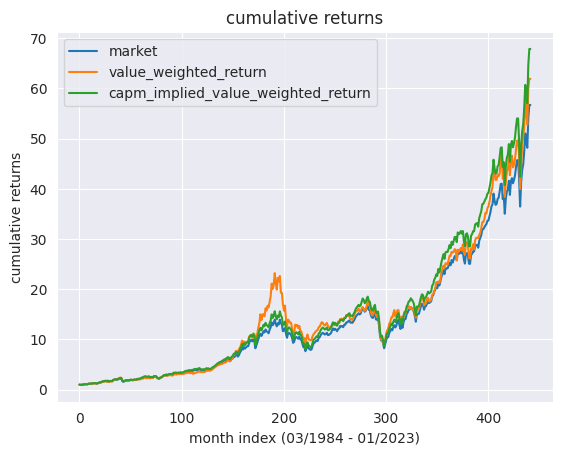

In [23]:
def plot_returns(df, strat_name):
    def cumreturns(vals):
        return (vals/100 + 1).cumprod()
        
    plt.title('cumulative returns')
    plt.xlabel('month index (03/1984 - 01/2023)')
    plt.ylabel('cumulative returns')

    ff_aligned = ff.loc[df.index]
    plt.plot(cumreturns((ff_aligned['Mkt-RF'] + ff_aligned['RF']).values), label='market')
    plt.plot(cumreturns(df[strat_name].values * 100), label=strat_name)

    alpha, beta, _ = get_capm(df[strat_name], print_capm=False)
    capm_implied_returns = beta * (ff_aligned['Mkt-RF']/100) + ff_aligned['RF']/100 + alpha

    plt.plot(cumreturns(capm_implied_returns.values * 100), label=f'capm_implied_{strat_name}')
    plt.legend()
    plt.show()

plot_returns(df, 'value_weighted_return')

Our strategy generally does worse than its benchmark (the capm implied returns).

In [28]:
df_pre2010 = df[df.index < 201001]
df_post2010 = df[df.index >= 201001]
print('pre 2010 model')
print('equal weighted')
get_carhart(df_pre2010['equal_weighted_return'])
print('value weighted')
get_carhart(df_pre2010['value_weighted_return'])
print()
print('post 2010 model')
print('equal weighted')
get_carhart(df_post2010['equal_weighted_return'])
print('value weighted')
get_carhart(df_post2010['value_weighted_return'])
print()
df_19982010 = df[(df.index < 201001) & (df.index >= 199801)]
print('post 1998 2010 model')
print('equal weighted')
get_carhart(df_19982010['equal_weighted_return'])
print('value weighted')
get_carhart(df_19982010['value_weighted_return'])
print()

pre 2010 model
equal weighted
const     0.002158
Mkt-RF    1.109689
SMB       0.150959
HML       0.036344
Mom      -0.071247
dtype: float64
p-value: (0.02416682991292844)
value weighted
const     0.002353
Mkt-RF    1.016386
SMB      -0.186577
HML      -0.320768
Mom      -0.064315
dtype: float64
p-value: (0.047071547724867206)

post 2010 model
equal weighted
const    -0.000293
Mkt-RF    1.059485
SMB       0.188108
HML      -0.095350
Mom      -0.016265
dtype: float64
p-value: (0.8329597120604503)
value weighted
const    -0.001560
Mkt-RF    1.099682
SMB      -0.158178
HML      -0.088581
Mom      -0.057771
dtype: float64
p-value: (0.31083888776033475)

post 1998 2010 model
equal weighted
const     0.004196
Mkt-RF    1.130380
SMB       0.143636
HML       0.104381
Mom      -0.052777
dtype: float64
p-value: (0.011021437343519227)
value weighted
const     0.002664
Mkt-RF    1.088888
SMB      -0.129101
HML      -0.373071
Mom      -0.042226
dtype: float64
p-value: (0.17910551714044007)



The strategy seems to work in the pre period, because alphas are positive and significant. However, in the post period, they're slightly negative and not significant, so the strategy probably doesn't work. When we select dates from 1998 to 2010, the alphas match the ones from table 4 pretty well.

In [ ]:
ff12 = pd.read_csv('12_Industry_Portfolios.CSV', skiprows=11, skipfooter=2730+1166, index_col=0, engine='python')
ff12 = ff12.shift(-1).dropna()
ff12

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
192607,3.97,3.68,2.42,3.47,5.14,1.97,2.17,-1.69,-0.71,4.25,4.47,4.34
192608,1.14,4.80,-0.07,-3.39,5.30,-0.34,2.41,2.04,0.21,0.69,-1.61,0.37
192609,-1.24,-8.23,-3.16,-0.78,-4.55,-5.38,-0.11,-2.63,-2.29,-0.57,-5.51,-2.73
192610,5.20,-0.19,3.82,0.01,5.11,4.79,1.63,3.71,6.43,5.42,2.34,2.10
192611,0.82,9.89,3.72,2.82,5.13,-1.78,1.99,-0.17,0.62,0.11,2.60,3.51
...,...,...,...,...,...,...,...,...,...,...,...,...
202209,9.94,-6.27,14.82,23.60,6.92,4.80,10.94,3.50,4.30,8.84,12.80,9.84
202210,5.27,-7.57,8.62,0.97,9.90,5.26,2.32,6.82,3.86,5.46,4.74,7.84
202211,-2.67,-27.47,-2.43,-4.16,-2.20,-7.91,-6.76,-1.15,-7.96,-1.73,-5.49,-4.91
202212,-0.28,28.35,7.28,2.87,3.09,9.77,13.45,-1.26,9.74,-1.02,6.46,8.14


In [ ]:
def get_ff12(stock_data, ff12, ff5):
    stock_returns = stock_data['value_weighted_return']
    stock_returns.name = "Month_Rtn"
    ff_data = stock_returns.to_frame().merge(ff12, left_index=True, right_index=True).merge(ff5, left_index=True, right_index=True)
    X = ff_data[['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other']] / 100 
    y = ff_data['Month_Rtn'] - ff_data['RF'] / 100
    X = sm.add_constant(X)
    ff_model = sm.OLS(y, X).fit()
    return ff_model.params

In [ ]:
df_pre1999 = df[df.index < 199901]
pre_ff12_model = get_ff12(df_pre1999, ff12, ff)
pre_ff12_model

const   -0.004152
NoDur    0.143857
Durbl    0.027045
Manuf    0.137419
Enrgy    0.125236
Chems    0.121689
BusEq    0.471313
Telcm    0.114851
Utils   -0.059783
Shops    0.001429
Hlth     0.146725
Money    0.060970
Other   -0.348801
dtype: float64

In [ ]:
df_post1999 = df[df.index >= 199912]
post_ff12_model = get_ff12(df_post1999, ff12, ff)
post_ff12_model

const   -0.002445
NoDur    0.118196
Durbl    0.036718
Manuf    0.028064
Enrgy    0.032388
Chems    0.044710
BusEq    0.516305
Telcm    0.031382
Utils   -0.133246
Shops   -0.009673
Hlth     0.102391
Money    0.123540
Other    0.028369
dtype: float64

Nondurable good companies and health companies are slightly less correlated with the performance of the portfolio after 1999, while manufacturing, energy, chemicals, telephone, and utilities become much less correlated. So we expect that the fraction of best companies that come from these industries has decreased. Business equipment, finance, and other industry types have become more correlated with the portfolio, so we expect these industry types to appear more frequently in the best companies to work for. 

3a.
Because we are creating a long strategy, much of the portfolio is correlated with the market. The best companies may span those with high beta and low beta, and perhaps the best companies are a representative group for market beta. Compared to a long-short strategy, a long strategy may be more attractive to retail investors because it is less complex and does not entail the risks of short-selling.

For an institutional investor, a long-short strategy may offer hedging benefits. Perhaps they already have enough market exposure and just need pure alpha, so the hedge fund strategy can deliver that.

3b. Before 2010, the CAPM model demonstrated that we had positive and significant alpha. As such, the exposure variables in the Carhart model could not fully explain our returns. Thus, our positive and significant alpha shows that financial markets do not fully price the value of employee satisfaction.

3c. Alpha has disappeared over time because sites like Glassdoor and LinkedIn are able to deliver information on employee satisfaction that trading firms can take advantage of. Edmans paper was quite popular and has a lot of citations, so it raised awareness that there was money here to be made, diminishing the potency of the strategy.

3d. There are a lot of sites / companies that hold valuable information of the attitudes employees hold to their companies, such as Bombora, Twitter, employee engagement sites, and others. We can take all of this real-time information and see what kinds of things employees are saying about their companies. We can use analytic tools such as machine learning to determine a written message's sentiment. Finally, we can aggregate this information into a quantitative metric that measures employee satisfaction.